In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import newton
from scipy.optimize import fsolve

In [2]:
def drift(length):
    drift_matrix = np.array([[1., length, 0., 0., 0., 0.],
                             [0., 1., 0., 0., 0., 0.],
                             [0., 0., 1., length, 0., 0.],
                             [0., 0., 0., 1., 0., 0.],
                             [0., 0., 0., 0., 1., 0.],
                             [0., 0., 0., 0., 0., 1.]])
    return drift_matrix

def quad(length, gauss, Brho, diameter):
    
    h = np.abs(gauss/Brho)
    c11 = np.cos(length*np.sqrt(10*h/diameter))
    c12 = np.sin(length*np.sqrt(10*h/diameter))/np.sqrt(10*h/diameter)
    c21 = -np.sin(length*np.sqrt(10*h/diameter))*np.sqrt(10*h/diameter)
    d11 = np.cosh(length*np.sqrt(10*h/diameter))
    d12 = np.sinh(length*np.sqrt(10*h/diameter))/np.sqrt(10*h/diameter)
    d21 = np.sinh(length*np.sqrt(10*h/diameter))*np.sqrt(10*h/diameter)
    
    quad_matrix = drift(length)
    
    
    if gauss > 0:
        quad_matrix = np.array([[c11, c12, 0., 0., 0., 0.],
                                [c21, c11, 0., 0., 0., 0.],
                                [0., 0., d11, d12, 0., 0.],
                                [0., 0., d21, d11, 0., 0.],
                                [0., 0., 0., 0., 1., 0.],
                                [0., 0., 0., 0., 0., 1.]])
    if gauss < 0:
        quad_matrix = np.array([[d11, d12, 0., 0., 0., 0.],
                                [d21, d11, 0., 0., 0., 0.],
                                [0., 0., c11, c12, 0., 0.],
                                [0., 0., c21, c11, 0., 0.],
                                [0., 0., 0., 0., 1., 0.],
                                [0., 0., 0., 0., 0., 1.]])
    return quad_matrix

def lens(f_length):
    lens_matrix = np.array([[1., 0., 0., 0., 0., 0.],
                            [-1/f_length, 1., 0., 0., 0., 0.],
                            [0., 0., 1., 0., 0., 0.],
                            [0., 0., -1/f_length, 1., 0., 0.],
                            [0., 0., 0., 0., 1., 0.],
                            [0., 0., 0., 0., 0., 1.]])
    return lens_matrix

def bend(length, gauss, Brho, n):
    
    h = gauss/Brho
    r11 = np.cos(length*h*np.sqrt(1-n))
    r12 = np.sin(length*h*np.sqrt(1-n))/(h*np.sqrt(1-n))
    r21 = -np.sin(length*h*np.sqrt(1-n))*(h*np.sqrt(1-n))
    r33 = np.cos(length*h*np.sqrt(n))
    r34 = np.sin(length*h*np.sqrt(n))/(h*np.sqrt(n))
    r43 = -np.sin(length*h*np.sqrt(n))*(h*np.sqrt(n))
    

    bend_matrix = np.array([[r11, r12, 0., 0., 0., 0.],
                            [r21, r11, 0., 0., 0., 0.],
                            [0., 0., r33, r34, 0., 0.],
                            [0., 0., r43, r33, 0., 0.],
                            [0., 0., 0., 0., 1., 0.],
                            [0., 0., 0., 0., 0., 1.]])

    return bend_matrix

Transport workflow:

Initialize and name trajectory.

set the kV.

define rays for plotting and optimization

add elements

effective length correction not implemented yet. Only works if there is a drift between each quad.

calculate rays and maps for optimization

optimize

calculate rays and maps for plotting, plot

In [192]:
class Transport:
    def __init__(self):
        
        self.ray_set = False # to raise exception of you try to plot or crunch without a ray
        self.rays = {} # to store initial ray values
        self.layer=0 #order of elements     
        self.elements={} #store element info to adjust elements
        self.column = [] #column configuration for calculations
        self.map = np.identity(6) #total map
        self.map_layers = [] #store the map state at each layer
        
    def set_kV(self, kV=100):
        self.kV = kV
        self.rel_kV = kV*(1+kV/1022)
        self.mv = np.sqrt(2*511*self.rel_kV)*.000001 #(GeV/c)
        self.Brho = 3.3356*self.mv 
        
    def set_ray(self, label, x=0, x_angle=0, y=0, y_angle=0):
        self.ray_set = True
        ray = np.array([x, x_angle, y, y_angle, 0, 0])
        ray_dict={}
        ray_dict['init'] = ray
        self.rays[label] = ray_dict
        
    def add_drift(self, label, length):
        layer = self.layer
        self.layer += 1
        el_dict = {}
        el_dict['layer'] = layer
        el_dict['type'] = 'drift'
        el_dict['length'] = length
        self.elements[label] = el_dict
            
    def add_quad(self, label, length, gauss, radius, slices=8):
        layer = self.layer
        self.layer += 1
        el_dict = {}
        el_dict['layer'] = layer
        el_dict['type'] = 'quad'
        el_dict['length'] = length
        el_dict['gauss'] = gauss
        el_dict['radius'] = radius
        el_dict['slices'] = slices
        self.elements[label] = el_dict
        
    def add_lens(self, label, f_length, slices=8):
        layer = self.layer
        self.layer += 1
        el_dict = {}
        el_dict['layer'] = layer
        el_dict['type'] = 'lens'
        el_dict['f_length'] = f_length
        el_dict['slices'] = slices
        self.elements[label] = el_dict
        
    def eff_length(self):
        return
    
    def crunch(self):
        
        self.column = [] #column configuration for calculations
        self.map = np.identity(6).copy() #total map
        self.map_layers = [] #store the map state at each layer
        self.axial_width_x = []
        self.axial_width_y = []
        self.axial_ang_x = []
        self.axial_ang_y = []
        self.field_width_x = []
        self.field_width_y = []
        self.field_ang_x = []
        self.field_ang_y = []        
        
        for key in self.elements:
            el = self.elements[key]
            if el['type']=='drift':
                drift_matrix = drift(el['length'])
                self.map = drift_matrix@self.map
                self.map_layers.append(self.map)
                self.column.append([el['length'], drift_matrix])
            if el['type'] == 'quad':      
                quad_matrix = quad(el['length'], el['gauss'], self.Brho, 2*el['radius'])
                self.map = quad_matrix@self.map
                self.map_layers.append(self.map)
                self.column.append([el['length'], quad_matrix])
                
            if el['type']=='lens':
                lens_matrix = lens(el['f_length'])
                self.map = lens_matrix@self.map
                self.map_layers.append(self.map)
                self.column.append([0, lens_matrix])
            
            xx = self.map[0,0]
            yy = self.map[2,2]
            xa = self.map[0,1]
            xb = self.map[0,3]
            
            self.axial_width_x.append(np.sqrt(xa**2+xb**2)*xa/np.abs(xa))
            
            
        
        self.axial_width_x = .0001*np.array(self.axial_width_x)
        
        if self.ray_set:
            for key in self.rays:

                ray = self.rays[key]['init'].copy()

                z = 0

                ray_x = []
                ray_a = []
                ray_y = []
                ray_b = []
                ray_z = []

                ray_x.append(ray[0])
                ray_a.append(ray[1])
                ray_y.append(ray[2])
                ray_b.append(ray[3])
                ray_z.append(z)

                for el in self.column:

                    length = el[0]
                    matrix = el[1]

                    z += length
                    ray = matrix@ray

                    ray_x.append(ray[0])
                    ray_a.append(ray[1])
                    ray_y.append(ray[2])
                    ray_b.append(ray[3])
                    ray_z.append(z)

                self.rays[key]['x'] = ray_x
                self.rays[key]['a'] = ray_a
                self.rays[key]['y'] = ray_y
                self.rays[key]['b'] = ray_b
                self.rays[key]['z'] = ray_z
        else:
            print('no rays have been set')
            
    def ray_func(self, in_val, in_label, in_param, out_label, out_ray, out_axis):
        self.elements[in_label][in_param] = in_val
        self.crunch()
        layer = self.elements[out_label]['layer']
        return self.rays[out_ray][out_axis][layer]
    
    def ray_goal(self, goal, in_label, in_param, out_label, out_ray, out_axis): 
        def out(x): #just to make things more compact
            put = self.ray_func(x, in_label=in_label, 
                                     in_param=in_param, 
                                     out_label=out_label, 
                                     out_ray=out_ray,
                                     out_axis=out_axis)
            return put-goal
        x0 = self.elements[in_label][in_param]
        root = newton(out, x0)
        self.elements[in_label][in_param] = root

        
        
    def map_func(self, in_vec, in_labels, in_params, out_label, out_mxs, out_mys):
        for idx, in_val in enumerate(in_vec):
            self.elements[in_labels[idx]][in_params[idx]] = in_val
        self.crunch()
        layer = self.elements[out_label]['layer']
        map_layer=self.map_layers[layer]
        return [map_layer[out_mxs[0], out_mys[0]], map_layer[out_mxs[1], out_mys[1]],
                map_layer[0, 0] - map_layer[2, 2]]
    
        
    def plot(self):
        
        if not self.ray_set:
            
            print('no rays have been set')
            
        #make column list:
        
        self.plot_column = []
        self.quad_shade_list = []
        self.lens_line_list = []
        z_el = 0
        for key in self.elements:
            el = self.elements[key]
            
            if el['type']=='drift':
                z_el += el['length']
                drift_matrix = drift(el['length'])
                self.plot_column.append([el['length'], drift_matrix])
            if el['type'] == 'quad':
                z0 = z_el
                z_el += el['length']
                z1 = z_el
                self.quad_shade_list.append([z0,z1])
                for i in range(el['slices']):           
                    quad_matrix = quad(el['length']/el['slices'], el['gauss'], self.Brho, 2*el['radius'])
                    self.plot_column.append([el['length']/el['slices'], quad_matrix])
                
            if el['type']=='lens':
                z0 = z_el
                self.lens_line_list.append(z0)
                lens_matrix = lens(el['f_length'])
                self.plot_column.append([0, lens_matrix])
        fignum=0
        for key in self.rays:
            
            
            
            ray = self.rays[key]['init'].copy()
            
            z = 0
            
            ray_x = []
            ray_y = []
            ray_z = []

            ray_x.append(ray[0])
            ray_y.append(ray[2])
            ray_z.append(z)
            

            
            for el in self.plot_column:
                
                length = el[0]
                matrix = el[1]
                
#                 z0=z
                z += length
#                 z1=z
#                 plt.axvspan(z0, z1, alpha=0.5, color='red')
                
                ray = matrix@ray
                
                ray_x.append(ray[0])
                ray_y.append(ray[2])
                ray_z.append(z)
                
                
                

            plt.figure(figsize=[11,4])            
            plt.title(key)
            plt.plot(ray_z, ray_x, label='x')
            plt.plot(ray_z, ray_y, label='y')
            plt.plot(ray_z, np.zeros(len(ray_z)), linestyle='dashed', color='black')
            plt.plot(ray_z, .0025*np.ones(len(ray_z)), linestyle='dashed', color='black')
            plt.plot(ray_z, -.0025*np.ones(len(ray_z)), linestyle='dashed', color='black')
            plt.legend()
            for pair in self.quad_shade_list:
                plt.axvspan(pair[0], pair[1], alpha=0.2, color='black')
            for z0 in self.lens_line_list:
                plt.axvline(x=z0, alpha=0.5, color='black')
                
            plt.savefig('fig{}.pdf'.format(fignum))
            fignum+=1

               
        

            
    def fit_quad_point_to_point(self, quad_list): 
        #sets up a point to point imaging system with three quads
        in_vec = []
        
        for quad in quad_list:
            in_vec.append(self.elements[quad]['gauss'])
        
        out_layer = self.elements[quad_list[2]]['layer']+1
        
        def out(in_vec): #just to make things more compact
            for idx, in_val in enumerate(in_vec):
                self.elements[quad_list[idx]]['gauss'] = in_val
            self.crunch()
            map_layer=self.map_layers[out_layer]
            return [map_layer[0, 1], map_layer[2,3], map_layer[0, 0] - map_layer[2, 2]]
        sol = fsolve(out, in_vec)
        for idx, quad in enumerate(quad_list):
            self.elements[quad]['gauss'] = sol[idx]
        return sol
        
    def fit_six_quad(self, quad_list): 
        #This was trying to make a 6 quad coupling into
        #the original cong design
        in_vec = []
        
        for quad in quad_list:
            in_vec.append(self.elements[quad]['gauss'])
        
        out_layer = self.elements[quad_list[-1]]['layer']+1
        
        def out(in_vec): #just to make things more compact
            for idx, in_val in enumerate(in_vec):
                self.elements[quad_list[idx]]['gauss'] = in_val
            self.crunch()
            map_layer = self.map_layers[out_layer]
            axial_x = self.rays['axial']['x'][out_layer]
            axial_a = self.rays['axial']['a'][out_layer]
            axial_y = self.rays['axial']['y'][out_layer]
            axial_b = self.rays['axial']['b'][out_layer]
            field_x = self.rays['field']['x'][out_layer]
            field_a = self.rays['field']['a'][out_layer]
            field_y = self.rays['field']['y'][out_layer]
            field_b = self.rays['field']['b'][out_layer]
#             return [axial_x**2-axial_y**2, 
#                     axial_a**2-axial_b**2, 
#                     axial_a**2-.01**2,
#                     field_x**2-field_y**2, 
#                     field_a**2-field_b**2, 
#                     field_a**2-.02**2]
#             return [axial_x**2-axial_y**2, 
#                     axial_a**2-axial_b**2, 
#                     axial_a**2+.01**2,0,0,0]
            return [field_x**2-axial_y**2, 
                    field_a**2-axial_b**2, 
                    field_a**2+.01**2,0,0,0,0]
        sol = fsolve(out, in_vec)
        for idx, quad in enumerate(quad_list):
            self.elements[quad]['gauss'] = sol[idx]
        return sol
        
#     def fit_six_quad(self, quad_list): 
        #This was trying to make a 6 quad coupling into
        #the original cong design
        #This is a version of the above where the objL can be
        #varied. Does not work very well
#         in_vec = []
        
#         for idx, quad in enumerate(quad_list):
#             if idx==0:
#                 in_vec.append(self.elements[quad]['f_length'])
#             else:
#                 in_vec.append(self.elements[quad]['gauss'])
        
#         out_layer = self.elements[quad_list[-1]]['layer']+1
        
#         def out(in_vec): #just to make things more compact
#             for idx, in_val in enumerate(in_vec):
#                 if idx == 0:
#                     self.elements[quad_list[idx]]['f_length'] = in_val
#                 else:
#                     self.elements[quad_list[idx]]['gauss'] = in_val   
#             self.crunch()
#             map_layer = self.map_layers[out_layer]
#             axial_x = self.rays['axial']['x'][out_layer]
#             axial_a = self.rays['axial']['a'][out_layer]
#             axial_y = self.rays['axial']['y'][out_layer]
#             axial_b = self.rays['axial']['b'][out_layer]
#             field_x = self.rays['field']['x'][out_layer]
#             field_a = self.rays['field']['a'][out_layer]
#             field_y = self.rays['field']['y'][out_layer]
#             field_b = self.rays['field']['b'][out_layer]
# #             return [axial_x**2-axial_y**2, 
# #                     axial_a**2-axial_b**2, 
# #                     axial_a**2+.05**2,
# #                     field_x**2-field_y**2, 
# #                     field_a**2-field_b**2, 
# #                     field_a**2+.1**2,
# #                     0]
# #             return [axial_x**2-axial_y**2, 
# #                     axial_a**2-axial_b**2, 
# #                     axial_a**2+.01**2,0,0,0]
#             return [field_x**2-axial_y**2, 
#                     field_a**2-axial_b**2, 
#                     field_a**2+.01,0,0,0,0,0]
#         sol = fsolve(out, in_vec)
#         for idx, quad in enumerate(quad_list):
#             self.elements[quad]['gauss'] = sol[idx]
#         return sol


    def fit_cong(self, quad_list1, quad_list2): 
        #sets up a point to point imaging system with three quads
        in_vec = []
        
        for quad in quad_list1:
            in_vec.append(self.elements[quad]['gauss'])
        
        out_layer = self.elements[quad_list1[-1]]['layer']+3
        
        def out(in_vec): #just to make things more compact
            for idx, in_val in enumerate(in_vec):
                self.elements[quad_list1[idx]]['gauss'] = in_val
            self.crunch()
            map_layer = self.map_layers[out_layer]
            axial_x = self.rays['axial']['x'][out_layer]
            axial_a = self.rays['axial']['a'][out_layer]
            axial_y = self.rays['axial']['y'][out_layer]
            axial_b = self.rays['axial']['b'][out_layer]
            field_x = self.rays['field']['x'][out_layer]
            field_a = self.rays['field']['a'][out_layer]
            field_y = self.rays['field']['y'][out_layer]
            field_b = self.rays['field']['b'][out_layer]
            return [(axial_a+axial_b)**2, 
                    (axial_x-axial_y)**2, 
                    (field_x+field_y)**2]
        sol = fsolve(out, in_vec)
        for idx, quad in enumerate(quad_list1):
            self.elements[quad]['gauss'] = sol[idx]
        for idx, quad in enumerate(quad_list2):
            self.elements[quad]['gauss'] = -sol[idx]
        return sol
    
    def fit_11quad(self, quad_list1, quad_list2): 
    #sets up a point to point imaging system with three quads
        in_vec = []

        for quad in quad_list1:
            in_vec.append(self.elements[quad]['gauss'])

        out_layer1 = self.elements[quad_list1[-1]]['layer']+3

        out_layer = self.elements[quad_list1[-1]]['layer']+3

        def out(in_vec): #just to make things more compact
            for idx, in_val in enumerate(in_vec):
                self.elements[quad_list1[idx]]['gauss'] = in_val
            self.crunch()
            map_layer = self.map_layers[out_layer1]
            axial_x = self.rays['axial']['x'][out_layer1]
            axial_a = self.rays['axial']['a'][out_layer1]
            axial_y = self.rays['axial']['y'][out_layer1]
            axial_b = self.rays['axial']['b'][out_layer1]
            field_x = self.rays['field']['x'][out_layer1]
            field_a = self.rays['field']['a'][out_layer1]
            field_y = self.rays['field']['y'][out_layer1]
            field_b = self.rays['field']['b'][out_layer1]
            return [(axial_a+axial_b)**2, 
                    (axial_x-axial_y)**2, 
                    (field_x+field_y)**2,0,0]
        sol = fsolve(out, in_vec)
        for idx, quad in enumerate(quad_list1):
            self.elements[quad]['gauss'] = sol[idx]
        for idx, quad in enumerate(quad_list2):
            self.elements[quad]['gauss'] = -sol[idx]
        return sol
    
    def fit_13quad(self, quad_list1, quad_list2): 
    #sets up a point to point imaging system with three quads
        in_vec = []

        for quad in quad_list1:
            in_vec.append(self.elements[quad]['gauss'])

        out_layer1 = self.elements[quad_list1[-1]]['layer']+3

        out_layer = self.elements[quad_list1[-1]]['layer']+3

        def out(in_vec): #just to make things more compact
            for idx, in_val in enumerate(in_vec):
                self.elements[quad_list1[idx]]['gauss'] = in_val
            self.crunch()
            map_layer = self.map_layers[out_layer1]
            axial_x = self.rays['axial']['x'][out_layer1]
            axial_a = self.rays['axial']['a'][out_layer1]
            axial_y = self.rays['axial']['y'][out_layer1]
            axial_b = self.rays['axial']['b'][out_layer1]
            field_x = self.rays['field']['x'][out_layer1]
            field_a = self.rays['field']['a'][out_layer1]
            field_y = self.rays['field']['y'][out_layer1]
            field_b = self.rays['field']['b'][out_layer1]
            return [(axial_a+axial_b)**2, 
                    (axial_x-axial_y)**2, 
                    (field_x+field_y)**2,
                    axial_x**2-.0025**2,0,0]
#             return [(axial_a+axial_b)**2, 
#                     (axial_x-axial_y)**2, 
#                     (field_x+field_y)**2,
#                     0,0,0]
        sol = fsolve(out, in_vec)
        for idx, quad in enumerate(quad_list1):
            self.elements[quad]['gauss'] = sol[idx]
        for idx, quad in enumerate(quad_list2):
            self.elements[quad]['gauss'] = -sol[idx]
        return sol
    
    def fit_3outquad(self, quad_list): 
        #Sets the exit angle and width after 3 quads
        in_vec = []
        
        for quad in quad_list:
            in_vec.append(self.elements[quad]['gauss'])
        
        out_layer = self.elements[quad_list[2]]['layer']+1
        
        def out(in_vec): #just to make things more compact
            for idx, in_val in enumerate(in_vec):
                self.elements[quad_list[idx]]['gauss'] = in_val
            self.crunch()
            map_layer=self.map_layers[out_layer]
            axial_x = self.rays['axial']['x'][out_layer]
            axial_a = self.rays['axial']['a'][out_layer]
            axial_y = self.rays['axial']['y'][out_layer]
            axial_b = self.rays['axial']['b'][out_layer]
            field_x = self.rays['field']['x'][out_layer]
            field_a = self.rays['field']['a'][out_layer]
            field_y = self.rays['field']['y'][out_layer]
            field_b = self.rays['field']['b'][out_layer]
            return [(axial_a-axial_b)**2+ 
                    (axial_x-axial_y)**2, 
                    (field_a-field_b)**2+
                    (field_x-field_y)**2,
                    (axial_a+.005)**2]
        sol = fsolve(out, in_vec)
        for idx, quad in enumerate(quad_list):
            self.elements[quad]['gauss'] = sol[idx]
        return sol
    
    def fit_4outquad(self, quad_list): 
        #Sets the exit angle and width after 3 quads
        in_vec = []
        
        for quad in quad_list:
            in_vec.append(self.elements[quad]['gauss'])
        
        out_layer = self.elements[quad_list[3]]['layer']+1
        
        def out(in_vec): #just to make things more compact
            for idx, in_val in enumerate(in_vec):
                self.elements[quad_list[idx]]['gauss'] = in_val
            self.crunch()
            map_layer=self.map_layers[out_layer]
            axial_x = self.rays['axial']['x'][out_layer]
            axial_a = self.rays['axial']['a'][out_layer]
            axial_y = self.rays['axial']['y'][out_layer]
            axial_b = self.rays['axial']['b'][out_layer]
            field_x = self.rays['field']['x'][out_layer]
            field_a = self.rays['field']['a'][out_layer]
            field_y = self.rays['field']['y'][out_layer]
            field_b = self.rays['field']['b'][out_layer]
            return [(axial_a-axial_b)**2+ 
                    (axial_x-axial_y)**2, 
                    (field_a-field_b)**2,
                    (field_x-field_y)**2,
                    (axial_a+.000)**2]
        sol = fsolve(out, in_vec)
        for idx, quad in enumerate(quad_list):
            self.elements[quad]['gauss'] = sol[idx]
        return sol
    
    def fit_5outquad(self, quad_list): 
        #Sets the exit angle and width after 3 quads
        in_vec = []
        
        for quad in quad_list:
            in_vec.append(self.elements[quad]['gauss'])
        
        out_layer = self.elements[quad_list[4]]['layer']+1
        
        def out(in_vec): #just to make things more compact
            for idx, in_val in enumerate(in_vec):
                self.elements[quad_list[idx]]['gauss'] = in_val
            self.crunch()
            map_layer=self.map_layers[out_layer]
            axial_x = self.rays['axial']['x'][out_layer]
            axial_a = self.rays['axial']['a'][out_layer]
            axial_y = self.rays['axial']['y'][out_layer]
            axial_b = self.rays['axial']['b'][out_layer]
            field_x = self.rays['field']['x'][out_layer]
            field_a = self.rays['field']['a'][out_layer]
            field_y = self.rays['field']['y'][out_layer]
            field_b = self.rays['field']['b'][out_layer]
            return [(axial_a-axial_b)**2, 
                    (axial_x-axial_y)**2, 
                    (field_a-field_b)**2,
                    (field_x-field_y)**2,
                    (axial_a+.005)**2]
        sol = fsolve(out, in_vec)
        for idx, quad in enumerate(quad_list):
            self.elements[quad]['gauss'] = sol[idx]
        return sol
    
    def cosy_column(self):
        quad_num = 1
        with open('ColumnFromNewDesign_12quad2.txt', 'w') as f:
            f.write('PROCEDURE COLUMNXL;\n')        
            for key in self.elements:
                if self.elements[key]['type'] == 'drift':
                    length = 1000*self.elements[key]['length']
                    f.write(f'Drift {length};\n')   
                if self.elements[key]['type'] == 'quad':
                    length = 1000*self.elements[key]['length']
                    diam = 2*self.elements[key]['radius']
                    f.write(f'QuadLayer {quad_num} {length} {diam};\n')
                    quad_num += 1
                if self.elements[key]['type'] == 'lens':
                    f.write(f'ThinLensA {key};\n')   
            f.write('ENDPROCEDURE;')
        return f.closed
    
    def cosy_excitation(self):
        quad_num = 1
        with open('test_excitation_12quad2.txt', 'w') as f:       
            for key in self.elements:  
                if self.elements[key]['type'] == 'quad':
                    gauss = .01*self.elements[key]['gauss']
                    f.write(f'Q({quad_num}):={gauss};\n')
                    quad_num += 1
                if self.elements[key]['type'] == 'lens':
                    f_length = self.elements[key]['f_length']
                    f.write(f'{key}(1):={f_length};\n')
                    f.write(f'{key}(2):={.667*f_length};\n')  
                    f.write(f'{key}(3):={f_length};\n')  
        return f.closed

array([ 0.6646867 , -0.2533967 , -0.46956923, -0.26614386,  1.14223474])

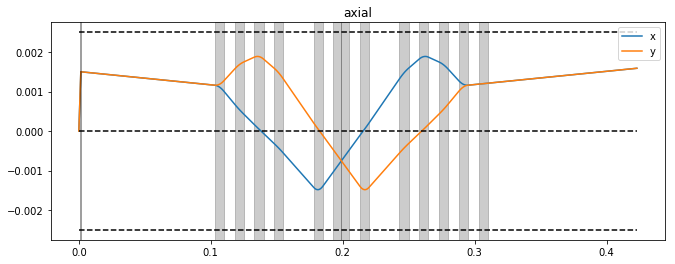

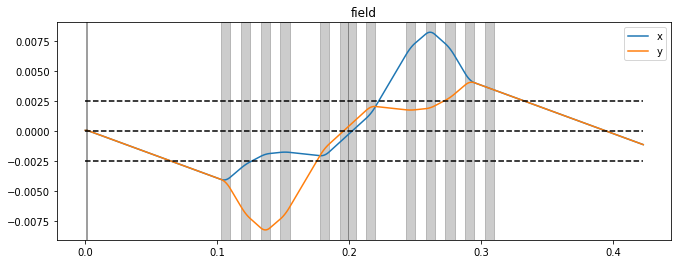

In [193]:
#bps5dec2018 
#Experimenting with different spacing

OFFSET_46=.00
OFFSET_GROUP1= -.015

sol = [0.36115056, -0.63687572,  0.83335557, -0.62391973,  0.84188378]
sol = [ 0.40054428, -0.62257435,  0.75139092, -0.62341641,  0.84178452]

sol =[ 0.44615566,  0.22104805, -0.69381728, -0.26614387,  1.1422347 ]


q10=sol[0]
q9=sol[1]
q8=sol[2]
q7=sol[3]
q6=sol[4]

gap = .008

pole = .007

pole_center = .012

traj_12quad=Transport()
traj_12quad.set_kV(100)
traj_12quad.set_ray('axial', x_angle=1, y_angle=1)
traj_12quad.set_ray('field', x=6e-5, y=6e-5)
traj_12quad.add_drift('drift_sample', length=0.0015)
# traj_12quad.add_lens('ObjL', f_length=.001496)
traj_12quad.add_lens('ObjL', f_length=.001495)
# traj_12quad.add_lens('ObjL', f_length=.001492)
traj_12quad.add_drift('drift_ObjL', length=.0885)
traj_12quad.add_drift('drift_prequads', length=.013)
traj_12quad.add_quad('quad10', length=pole, gauss=q10, radius=.625)
traj_12quad.add_drift('drift10', length=gap)
traj_12quad.add_quad('quad9', length=pole, gauss=q9, radius=.625)
traj_12quad.add_drift('drift9', length=gap)
traj_12quad.add_quad('quad8', length=pole, gauss=q8, radius=.625)
traj_12quad.add_drift('drift8', length=gap)
traj_12quad.add_quad('quad7', length=pole, gauss=q7, radius=.625)
traj_12quad.add_drift('drift7', length=gap+OFFSET_46-OFFSET_GROUP1)
traj_12quad.add_quad('quad6', length=pole, gauss=q6, radius=.625)
traj_12quad.add_drift('drift6', length=gap-OFFSET_46)
# traj_12quad.add_quad('quad5', length=pole_center, gauss=1e-20, radius=.625)
traj_12quad.add_quad('quad5_1', length=pole_center/2, gauss=1e-20, radius=.625)
traj_12quad.add_quad('quad5_2', length=pole_center/2, gauss=1e-20, radius=.625)
traj_12quad.add_drift('drift5', length=gap-OFFSET_46)
traj_12quad.add_quad('quad4', length=pole, gauss=-q6, radius=.625)
traj_12quad.add_drift('drift4', length=gap+OFFSET_46-OFFSET_GROUP1)
traj_12quad.add_quad('quad3', length=pole, gauss=-q7, radius=.625)
traj_12quad.add_drift('drift3', length=gap)
traj_12quad.add_quad('quad2', length=pole, gauss=-q8, radius=.625)
traj_12quad.add_drift('drift2', length=gap)
traj_12quad.add_quad('quad1', length=pole, gauss=-q9, radius=.625)
traj_12quad.add_drift('drift1', length=gap)
traj_12quad.add_quad('quad0', length=pole, gauss=-q10, radius=.625)
traj_12quad.add_drift('drift0', length=gap)
traj_12quad.add_quad('quadf', length=pole, gauss=1e-20, radius=.625)
traj_12quad.add_drift('drift_postquads', length=.013)
# traj_12quad.add_drift('drift_lens3_1', length=.016)
# traj_12quad.add_lens('C2', f_length=.1)
# traj_12quad.add_drift('drift_lens3_2', length=.044)
traj_12quad.add_drift('drift_final', length=.1)
# traj_12quad.plot()

sol = traj_12quad.fit_11quad(['quad10', 'quad9', 'quad8', 'quad7', 'quad6'],
                             ['quad0', 'quad1', 'quad2', 'quad3', 'quad4'])
traj_12quad.plot()

sol

array([ 0.40361866, -0.98227066,  0.13188419])

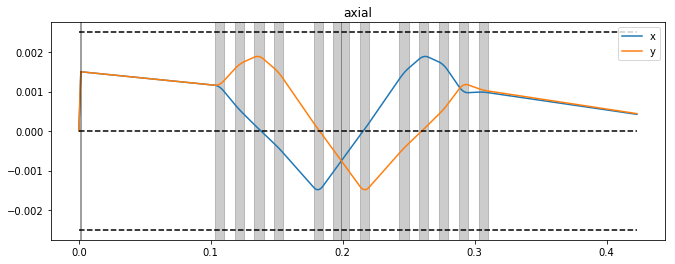

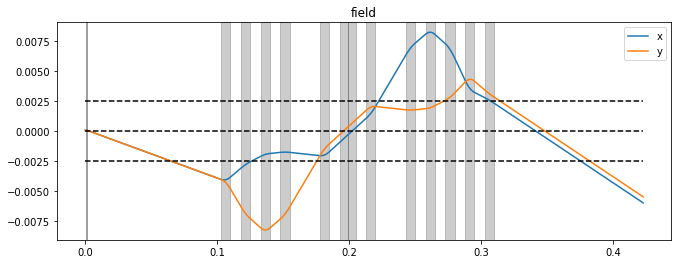

In [194]:
sol = traj_12quad.fit_3outquad(['quad1', 'quad0', 'quadf'])
traj_12quad.plot()

sol

In [178]:
traj_12quad.cosy_column()
traj_12quad.cosy_excitation()



True

array([ 0.60355096, -0.74378838,  0.67713693, -0.48940847,  0.03363301])

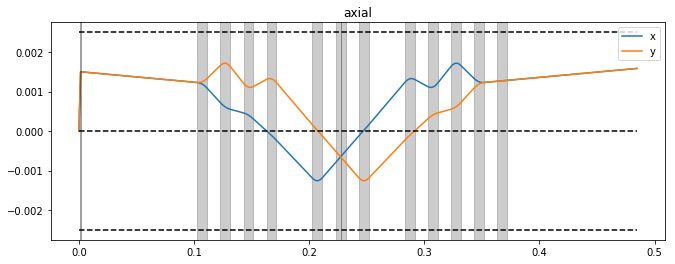

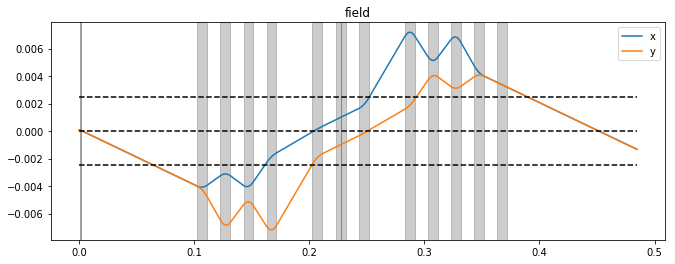

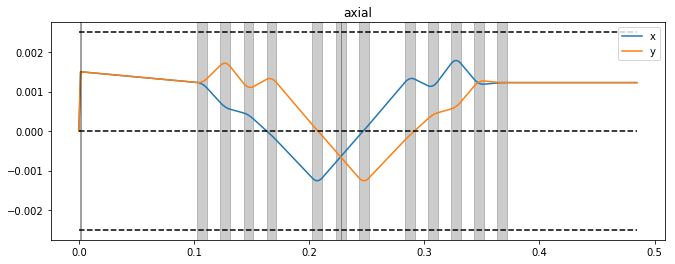

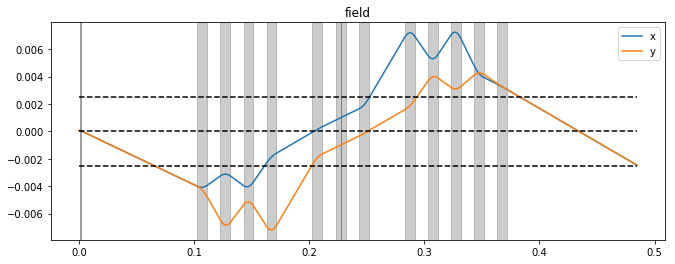

In [181]:
#bps5dec2018 
#Working model with cong spacing and polepiece length

OFFSET_46=-.0001
OFFSET_GROUP1= -.02

sol = [0.36115056, -0.63687572,  0.83335557, -0.62391973,  0.84188378]
sol = [ 0.40054428, -0.62257435,  0.75139092, -0.62341641,  0.84178452]


q10=sol[0]
q9=sol[1]
q8=sol[2]
q7=sol[3]
q6=sol[4]

gap = .011375

pole = .008625

traj_12quad=Transport()
traj_12quad.set_kV(100)
traj_12quad.set_ray('axial', x_angle=1, y_angle=1)
traj_12quad.set_ray('field', x=6e-5, y=6e-5)
traj_12quad.add_drift('drift_sample', length=0.0015)
traj_12quad.add_lens('ObjL', f_length=.001496)
# traj_12quad.add_lens('ObjL', f_length=.0014965)
traj_12quad.add_drift('drift_ObjL', length=.0885)
traj_12quad.add_drift('drift_prequads', length=.013)
traj_12quad.add_quad('quad10', length=pole, gauss=q10, radius=.625)
traj_12quad.add_drift('drift10', length=gap)
traj_12quad.add_quad('quad9', length=pole, gauss=q9, radius=.625)
traj_12quad.add_drift('drift9', length=gap)
traj_12quad.add_quad('quad8', length=pole, gauss=q8, radius=.625)
traj_12quad.add_drift('drift8', length=gap)
traj_12quad.add_quad('quad7', length=pole, gauss=q7, radius=.625)
traj_12quad.add_drift('drift7', length=gap+OFFSET_46-OFFSET_GROUP1)
traj_12quad.add_quad('quad6', length=pole, gauss=q6, radius=.625)
traj_12quad.add_drift('drift6', length=gap-OFFSET_46)
# traj_12quad.add_quad('quad5', length=pole, gauss=1e-20, radius=.625)
traj_12quad.add_quad('quad5_1', length=pole/2, gauss=1e-20, radius=.625)
traj_12quad.add_quad('quad5_2', length=pole/2, gauss=1e-20, radius=.625)
traj_12quad.add_drift('drift5', length=gap-OFFSET_46)
traj_12quad.add_quad('quad4', length=pole, gauss=-q6, radius=.625)
traj_12quad.add_drift('drift4', length=gap+OFFSET_46-OFFSET_GROUP1)
traj_12quad.add_quad('quad3', length=pole, gauss=-q7, radius=.625)
traj_12quad.add_drift('drift3', length=gap)
traj_12quad.add_quad('quad2', length=pole, gauss=-q8, radius=.625)
traj_12quad.add_drift('drift2', length=gap)
traj_12quad.add_quad('quad1', length=pole, gauss=-q9, radius=.625)
traj_12quad.add_drift('drift1', length=gap)
traj_12quad.add_quad('quad0', length=pole, gauss=-q10, radius=.625)
traj_12quad.add_drift('drift0', length=gap)
traj_12quad.add_quad('quadf', length=pole, gauss=.0000001, radius=.625)
traj_12quad.add_drift('drift_postquads', length=.013)
# traj_12quad.add_drift('drift_lens3_1', length=.016)
# traj_12quad.add_lens('C2', f_length=.1)
# traj_12quad.add_drift('drift_lens3_2', length=.044)
traj_12quad.add_drift('drift_final', length=.1)
# traj_12quad.plot()

sol = traj_12quad.fit_11quad(['quad10', 'quad9', 'quad8', 'quad7', 'quad6'],
                             ['quad0', 'quad1', 'quad2', 'quad3', 'quad4'])
traj_12quad.plot()

sol

sol = traj_12quad.fit_5outquad(['quad3','quad2', 'quad1', 'quad0', 'quadf'])
traj_12quad.plot()

sol

array([ 0.26976484, -0.07129388, -0.47533819,  0.83384698, -0.62161017,
        0.84289221])

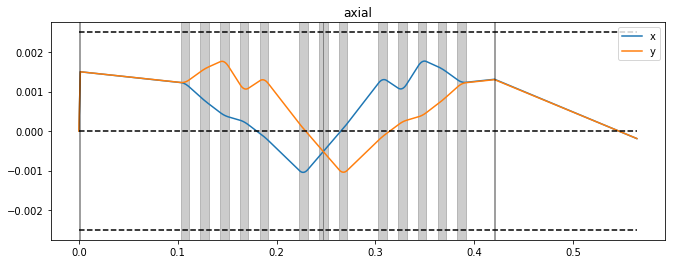

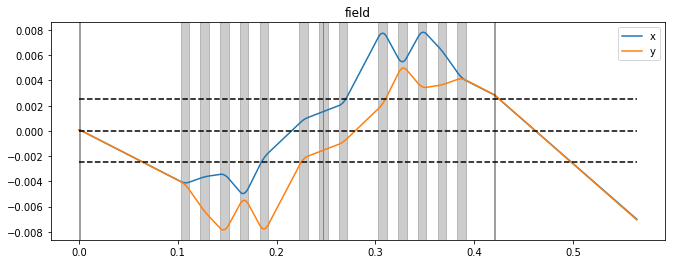

In [29]:
#bps2dec2018 
#current working cell
#working towards a trajectory that converges out of the
#corrector

OFFSET_46=-.0
OFFSET_GROUP1= -.02

sol = [0.0000001, 0.36115056, -0.63687572,  0.83335557, -0.62391973,  0.84188378]

sol = [ 0.26942918, -0.07135238, -0.47533886,  0.8339441 , -0.62161017, 0.84289221]

q11=sol[0]
q10=sol[1]
q9=sol[2]
q8=sol[3]
q7=sol[4]
q6=sol[5]
traj_13quad=Transport()
traj_13quad.set_kV(100)
traj_13quad.set_ray('axial', x_angle=1, y_angle=1)
traj_13quad.set_ray('field', x=6e-5, y=6e-5)
traj_13quad.add_drift('drift_sample', length=0.0015)
traj_13quad.add_lens('ObjL', f_length=.001496)
traj_13quad.add_drift('drift_ObjL', length=.0885)
traj_13quad.add_drift('drift_prequads', length=.013)
traj_13quad.add_quad('quad11', length=.008625, gauss=q11, radius=.625)
traj_13quad.add_drift('drift11', length=.011375)
traj_13quad.add_quad('quad10', length=.008625, gauss=q10, radius=.625)
traj_13quad.add_drift('drift10', length=.011375)
traj_13quad.add_quad('quad9', length=.008625, gauss=q9, radius=.625)
traj_13quad.add_drift('drift9', length=.011375)
traj_13quad.add_quad('quad8', length=.008625, gauss=q8, radius=.625)
traj_13quad.add_drift('drift8', length=.011375)
traj_13quad.add_quad('quad7', length=.008625, gauss=q7, radius=.625)
traj_13quad.add_drift('drift7', length=.011375+OFFSET_46-OFFSET_GROUP1)
traj_13quad.add_quad('quad6', length=.008625, gauss=q6, radius=.625)
traj_13quad.add_drift('drift6', length=.011375-OFFSET_46)
traj_13quad.add_quad('quad5_1', length=.008625/2, gauss=1e-20, radius=.625)
traj_13quad.add_quad('quad5_2', length=.008625/2, gauss=1e-20, radius=.625)
traj_13quad.add_drift('drift5', length=.011375-OFFSET_46)
traj_13quad.add_quad('quad4', length=.008625, gauss=-q6, radius=.625)
traj_13quad.add_drift('drift4', length=.011375+OFFSET_46-OFFSET_GROUP1)
traj_13quad.add_quad('quad3', length=.008625, gauss=-q7, radius=.625)
traj_13quad.add_drift('drift3', length=.011375)
traj_13quad.add_quad('quad2', length=.008625, gauss=-q8, radius=.625)
traj_13quad.add_drift('drift2', length=.011375)
traj_13quad.add_quad('quad1', length=.008625, gauss=-q9, radius=.625)
traj_13quad.add_drift('drift1', length=.011375)
traj_13quad.add_quad('quad0', length=.008625, gauss=-q10, radius=.625)
traj_13quad.add_drift('drift0', length=.011375)
traj_13quad.add_quad('quadf', length=.008625, gauss=-q11, radius=.625)
traj_13quad.add_drift('drift_postquads', length=.013)
traj_13quad.add_drift('drift_lens3_1', length=.016)
traj_13quad.add_lens('lens3', f_length=.1)
traj_13quad.add_drift('drift_lens3_2', length=.044)
traj_13quad.add_drift('drift_final', length=.1)
# traj_13quad.plot()

sol = traj_13quad.fit_13quad(['quad11','quad10', 'quad9', 'quad8', 'quad7', 'quad6'],
                             ['quadf','quad0', 'quad1', 'quad2', 'quad3', 'quad4'])
traj_13quad.plot()

sol

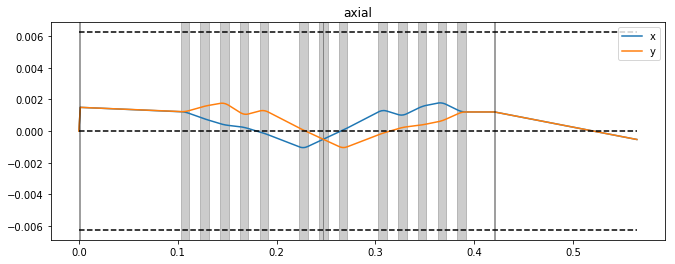

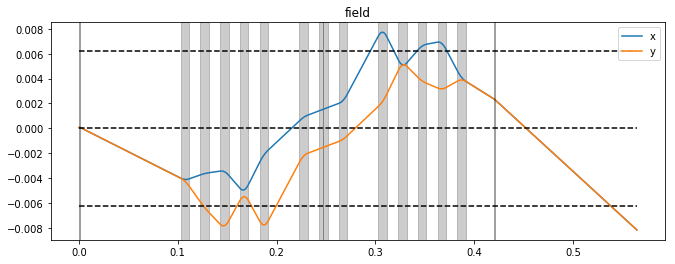

In [24]:
sol = traj_13quad.fit_outquad(['quad3','quad2', 'quad1', 'quad0', 'quadf'])
traj_13quad.plot()

array([ 0.40212785, -0.61792832,  0.74165493, -0.62387168,  0.84194096])

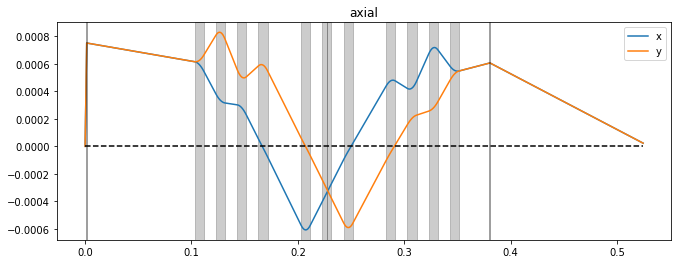

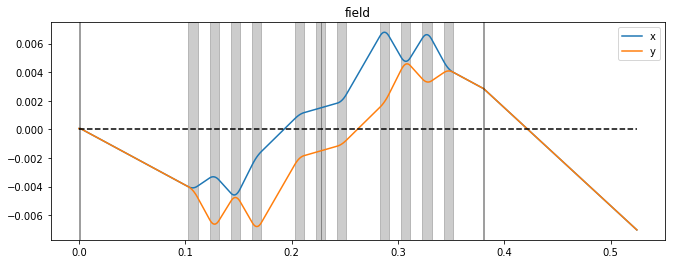

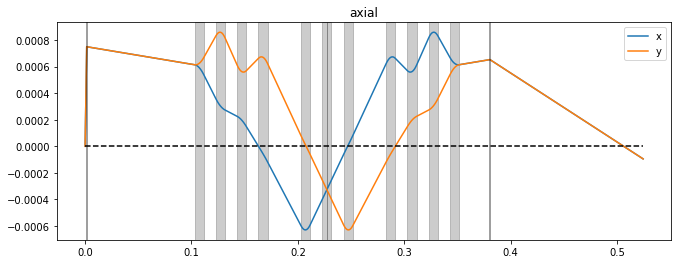

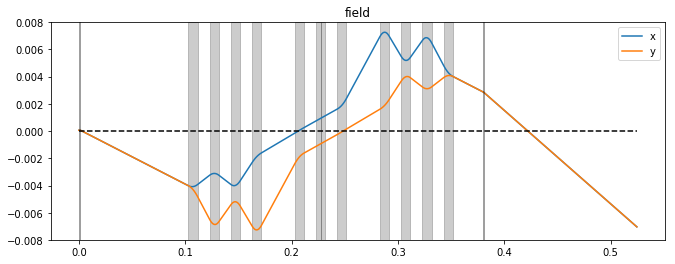

In [553]:
#bps2dec2018 
#This is the first working version of the 11quad setup
#The fitting function version used for this is included
#The function would need to be added to the Transport
#class to work properly

#     def fit_11quad(self, quad_list1, quad_list2): 
#     #sets up a point to point imaging system with three quads
#         in_vec = []

#         for quad in quad_list1:
#             in_vec.append(self.elements[quad]['gauss'])

#         out_layer1 = self.elements[quad_list1[-1]]['layer']+3

#         out_layer = self.elements[quad_list1[-1]]['layer']+3

#         def out(in_vec): #just to make things more compact
#             for idx, in_val in enumerate(in_vec):
#                 self.elements[quad_list1[idx]]['gauss'] = in_val
#             self.crunch()
#             map_layer = self.map_layers[out_layer1]
#             axial_x = self.rays['axial']['x'][out_layer1]
#             axial_a = self.rays['axial']['a'][out_layer1]
#             axial_y = self.rays['axial']['y'][out_layer1]
#             axial_b = self.rays['axial']['b'][out_layer1]
#             field_x = self.rays['field']['x'][out_layer1]
#             field_a = self.rays['field']['a'][out_layer1]
#             field_y = self.rays['field']['y'][out_layer1]
#             field_b = self.rays['field']['b'][out_layer1]
#             return [(axial_a+axial_b)**2, 
#                     (axial_x-axial_y)**2, 
#                     (field_x+field_y)**2,0,0]
#         sol = fsolve(out, in_vec)
#         for idx, quad in enumerate(quad_list1):
#             self.elements[quad]['gauss'] = sol[idx]
#         for idx, quad in enumerate(quad_list2):
#             self.elements[quad]['gauss'] = -sol[idx]
#         return sol



# OFFSET_46= .003750000000000000
# OFFSET_GROUP1= -.006110000000000000

OFFSET_46=-.0
OFFSET_GROUP1= -.02



sol = [0.54285266, -0.65274419, 0.54285266, -0.65274419,  0.84739947]

sol = [ 0.49770195, -0.67760134,  0.62616554, -0.62724881,  0.85983128]

sol = [ 0.36115056, -0.63687572,  0.83335557, -0.62391973,  0.84188378]


q10=sol[0]
q9=sol[1]
q8=sol[2]
q7=sol[3]
q6=sol[4]


traj_11quad=Transport()

traj_11quad.set_kV(100)

traj_11quad.set_ray('axial', x_angle=.5, y_angle=.5)

traj_11quad.set_ray('field', x=6e-5, y=6e-5)

traj_11quad.add_drift('drift_sample', length=0.0015)

# traj_11quad.add_lens('ObjL', f_length=.001479)

# traj_11quad.add_lens('ObjL', f_length=.001495)

traj_11quad.add_lens('ObjL', f_length=.001496)

traj_11quad.add_drift('drift_ObjL', length=.0885)

traj_11quad.add_drift('drift_prequads', length=.013)

traj_11quad.add_quad('quad10', length=.008625, gauss=q10, radius=.625)

traj_11quad.add_drift('drift10', length=.011375)

traj_11quad.add_quad('quad9', length=.008625, gauss=q9, radius=.625)

traj_11quad.add_drift('drift9', length=.011375)

traj_11quad.add_quad('quad8', length=.008625, gauss=q8, radius=.625)

traj_11quad.add_drift('drift8', length=.011375)

traj_11quad.add_quad('quad7', length=.008625, gauss=q7, radius=.625)

traj_11quad.add_drift('drift7', length=.011375+OFFSET_46-OFFSET_GROUP1)

traj_11quad.add_quad('quad6', length=.008625, gauss=q6, radius=.625)

traj_11quad.add_drift('drift6', length=.011375-OFFSET_46)

traj_11quad.add_quad('quad5_1', length=.008625/2, gauss=1e-20, radius=.625)
traj_11quad.add_quad('quad5_2', length=.008625/2, gauss=1e-20, radius=.625)

traj_11quad.add_drift('drift5', length=.011375-OFFSET_46)

traj_11quad.add_quad('quad4', length=.008625, gauss=-q6, radius=.625)

traj_11quad.add_drift('drift4', length=.011375+OFFSET_46-OFFSET_GROUP1)

traj_11quad.add_quad('quad3', length=.008625, gauss=-q7, radius=.625)

traj_11quad.add_drift('drift3', length=.011375)

traj_11quad.add_quad('quad2', length=.008625, gauss=-q8, radius=.625)

traj_11quad.add_drift('drift2', length=.011375)

traj_11quad.add_quad('quad1', length=.008625, gauss=-q9, radius=.625)

traj_11quad.add_drift('drift1', length=.011375)

traj_11quad.add_quad('quad0', length=.008625, gauss=-q10, radius=.625)

traj_11quad.add_drift('drift_postquads', length=.013)

traj_11quad.add_drift('drift_lens3_1', length=.016)

traj_11quad.add_lens('lens3', f_length=.1)

traj_11quad.add_drift('drift_lens3_2', length=.044)

traj_11quad.add_drift('drift_final', length=.1)

traj_11quad.plot()

sol = traj_11quad.fit_11quad(['quad10', 'quad9', 'quad8', 'quad7', 'quad6'], ['quad0', 'quad1', 'quad2', 'quad3', 'quad4'])


traj_11quad.plot()

sol

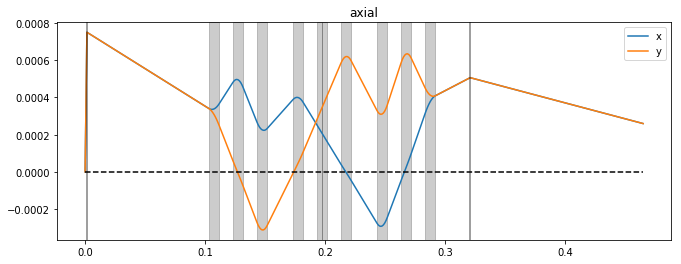

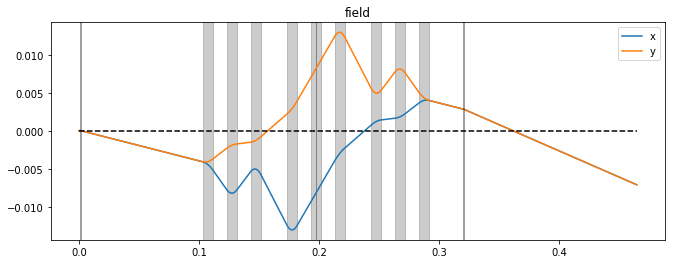

In [549]:
# OFFSET_46= .003750000000000000
# OFFSET_GROUP1= -.006110000000000000

OFFSET_46=-.0
OFFSET_GROUP1= -.01



sol = [0.54285266, -0.65274419, 0.54285266, -0.65274419,  0.84739947]

sol = [ 0.49770195, -0.67760134,  0.62616554, -0.62724881,  0.85983128]

sol = [ 0.36115056, -0.63687572,  0.83335557, -0.62391973,  0.84188378]

sol = [-0.7135086 ,  0.97730265, -2.11356288,  0.76539183] #heart

sol = [-0.66396378,  0.87356157, -1.61333477,  0.73237158]

# q10=sol[0]
# q9=sol[1]
# q8=sol[2]
# q7=sol[3]
# q6=sol[4]

q9=sol[0]
q8=sol[1]
q7=sol[2]
q6=sol[3]

traj_11quad1=Transport()

traj_11quad1.set_kV(100)

traj_11quad1.set_ray('axial', x_angle=.5, y_angle=.5)

traj_11quad1.set_ray('field', x=6e-5, y=6e-5)

traj_11quad1.add_drift('drift_sample', length=0.0015)

# traj_11quad1.add_lens('ObjL', f_length=.001479)

# traj_11quad1.add_lens('ObjL', f_length=.001495)

traj_11quad1.add_lens('ObjL', f_length=.001488)

traj_11quad1.add_drift('drift_ObjL', length=.0885)

# traj_11quad1.add_drift('drift_lens1_1', length=.016)

# traj_11quad1.add_lens('lens1', f_length=.048)

# traj_11quad1.add_drift('drift_lens1_2', length=.044)

# traj_11quad1.add_drift('drift_gap', length=.06)

# traj_11quad1.add_drift('drift_lens2_1', length=.044)

# # traj_11quad1.add_lens('lens2', f_length=.06)

# traj_11quad1.add_lens('lens2', f_length=.1)

# traj_11quad1.add_drift('drift_lens2_2', length=.016)

traj_11quad1.add_drift('drift_prequads', length=.013)

# traj_11quad1.add_quad('quad10', length=.008625, gauss=q10, radius=.625)

# traj_11quad1.add_drift('drift10', length=.011375)

traj_11quad1.add_quad('quad9', length=.008625, gauss=q9, radius=.625)

traj_11quad1.add_drift('drift9', length=.011375)

traj_11quad1.add_quad('quad8', length=.008625, gauss=q8, radius=.625)

traj_11quad1.add_drift('drift8', length=.011375)

traj_11quad1.add_quad('quad7', length=.008625, gauss=q7, radius=.625)

traj_11quad1.add_drift('drift7', length=.011375+OFFSET_46-OFFSET_GROUP1)

traj_11quad1.add_quad('quad6', length=.008625, gauss=q6, radius=.625)

traj_11quad1.add_drift('drift6', length=.011375-OFFSET_46)

traj_11quad1.add_quad('quad5_1', length=.008625/2, gauss=1e-20, radius=.625)
traj_11quad1.add_quad('quad5_2', length=.008625/2, gauss=1e-20, radius=.625)

traj_11quad1.add_drift('drift5', length=.011375-OFFSET_46)

traj_11quad1.add_quad('quad4', length=.008625, gauss=-q6, radius=.625)

traj_11quad1.add_drift('drift4', length=.011375+OFFSET_46-OFFSET_GROUP1)

traj_11quad1.add_quad('quad3', length=.008625, gauss=-q7, radius=.625)

traj_11quad1.add_drift('drift3', length=.011375)

traj_11quad1.add_quad('quad2', length=.008625, gauss=-q8, radius=.625)

traj_11quad1.add_drift('drift2', length=.011375)

traj_11quad1.add_quad('quad1', length=.008625, gauss=-q9, radius=.625)

# traj_11quad1.add_drift('drift1', length=.011375)

# traj_11quad1.add_quad('quad0', length=.008625, gauss=-q10, radius=.625)

traj_11quad1.add_drift('drift_postquads', length=.013)

traj_11quad1.add_drift('drift_lens3_1', length=.016)

traj_11quad1.add_lens('lens3', f_length=.1)

traj_11quad1.add_drift('drift_lens3_2', length=.044)

traj_11quad1.add_drift('drift_final', length=.1)

traj_11quad1.plot()

# sol = traj_11quad.fit_11quad(['quad10', 'quad9', 'quad8', 'quad7', 'quad6'], ['quad0', 'quad1', 'quad2', 'quad3', 'quad4'])
sol = traj_11quad1.fit_11quad(['quad9', 'quad8', 'quad7', 'quad6'], ['quad1', 'quad2', 'quad3', 'quad4'])

# sol = traj_11quad1.fit_quad_point_to_point(['quad3', 'quad2', 'quad1'])
traj_11quad1.plot()

sol

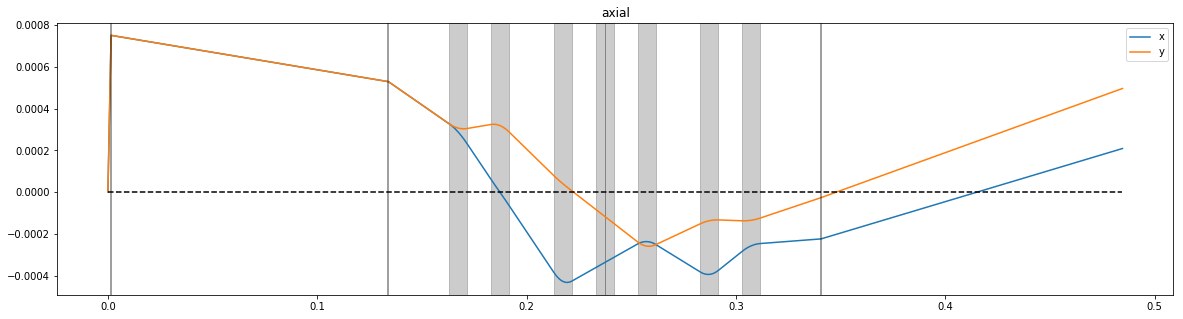

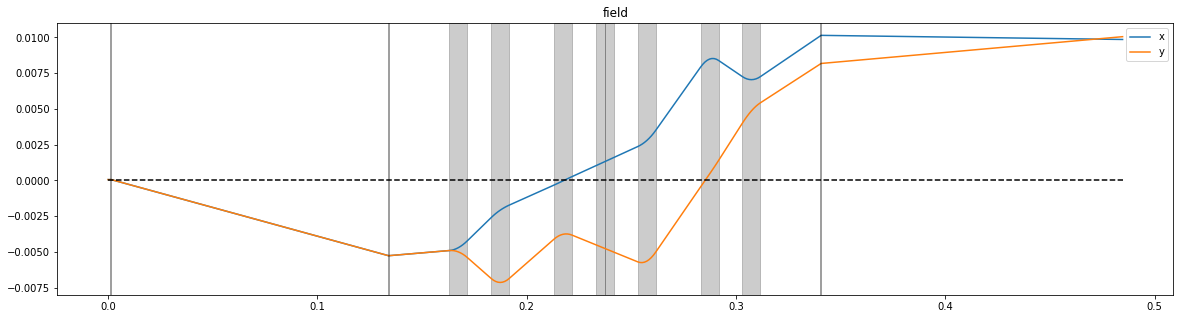

In [454]:
# OFFSET_46= .003750000000000000
# OFFSET_GROUP1= -.006110000000000000

OFFSET_46=-.0
OFFSET_GROUP1= -.01



sol = [ 0.54285266, -0.65274419,  0.84739947]

sol = [ 0.51525899, -0.67469238,  0.89553674]

sol = [ 0.4522582 , -0.59100995,  0.79495502]

q8=sol[0]
q7=sol[1]
q6=sol[2]

traj_cong=Transport()

traj_cong.set_kV(100)

traj_cong.set_ray('axial', x_angle=.5, y_angle=.5)

traj_cong.set_ray('field', x=6e-5, y=6e-5)

traj_cong.add_drift('drift_sample', length=0.0015)

# traj_cong.add_lens('ObjL', f_length=.001479)

traj_cong.add_lens('ObjL', f_length=.001495)

traj_cong.add_drift('drift_ObjL', length=.0885)

# traj_cong.add_drift('drift_lens1_1', length=.016)

# traj_cong.add_lens('lens1', f_length=.048)

# traj_cong.add_drift('drift_lens1_2', length=.044)

# traj_cong.add_drift('drift_gap', length=.06)

traj_cong.add_drift('drift_lens2_1', length=.044)

# traj_cong.add_lens('lens2', f_length=.06)

traj_cong.add_lens('lens2', f_length=.1)

traj_cong.add_drift('drift_lens2_2', length=.016)

traj_cong.add_drift('drift_prequads', length=.013)

traj_cong.add_quad('quad8', length=.008625, gauss=q8, radius=.625)

traj_cong.add_drift('drift8', length=.011375)

traj_cong.add_quad('quad7', length=.008625, gauss=q7, radius=.625)

traj_cong.add_drift('drift7', length=.011375+OFFSET_46-OFFSET_GROUP1)

traj_cong.add_quad('quad6', length=.008625, gauss=q6, radius=.625)

traj_cong.add_drift('drift6', length=.011375-OFFSET_46)

traj_cong.add_quad('quad5_1', length=.008625/2, gauss=1e-20, radius=.625)
traj_cong.add_quad('quad5_2', length=.008625/2, gauss=1e-20, radius=.625)

traj_cong.add_drift('drift5', length=.011375-OFFSET_46)

traj_cong.add_quad('quad4', length=.008625, gauss=-q6, radius=.625)

traj_cong.add_drift('drift4', length=.011375+OFFSET_46-OFFSET_GROUP1)

traj_cong.add_quad('quad3', length=.008625, gauss=-q7, radius=.625)

traj_cong.add_drift('drift3', length=.011375)

traj_cong.add_quad('quad2', length=.008625, gauss=-q8, radius=.625)

traj_cong.add_drift('drift_postquads', length=.013)

traj_cong.add_drift('drift_lens3_1', length=.016)

traj_cong.add_lens('lens3', f_length=.1)

traj_cong.add_drift('drift_lens3_2', length=.044)

traj_cong.add_drift('drift_final', length=.1)

traj_cong.plot()

array([ 0.51868846, -0.74341574,  0.99622848])

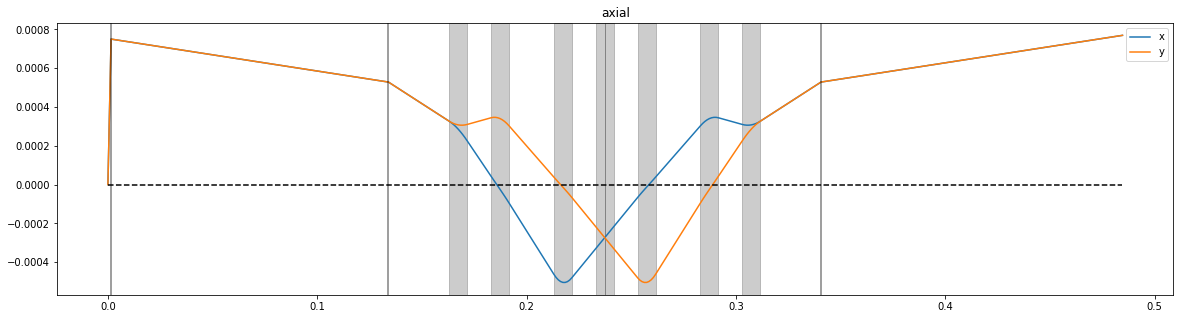

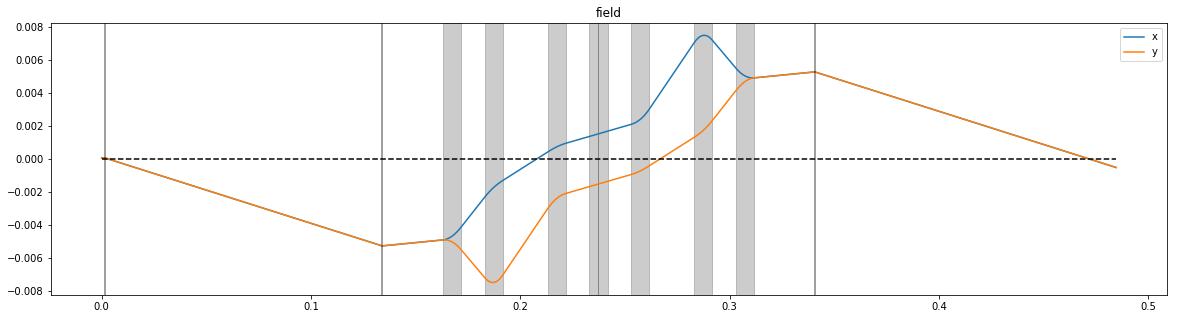

In [429]:
sol = traj_cong.fit_cong(['quad8', 'quad7', 'quad6'], ['quad2', 'quad3', 'quad4'])

traj_cong.plot()

sol

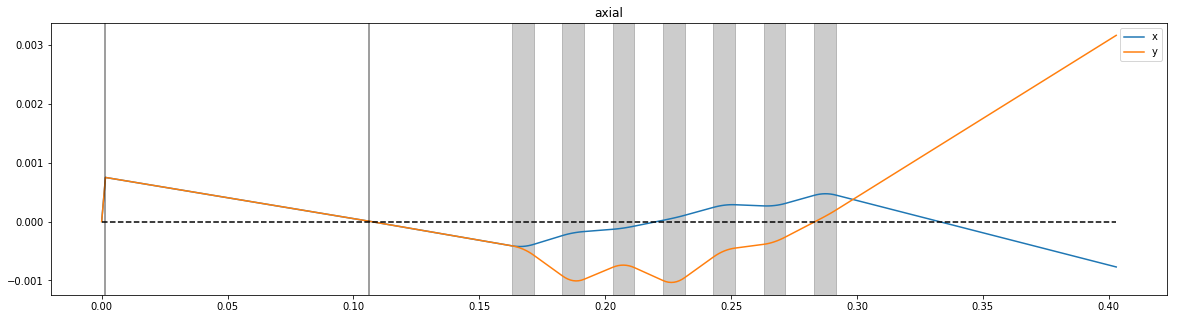

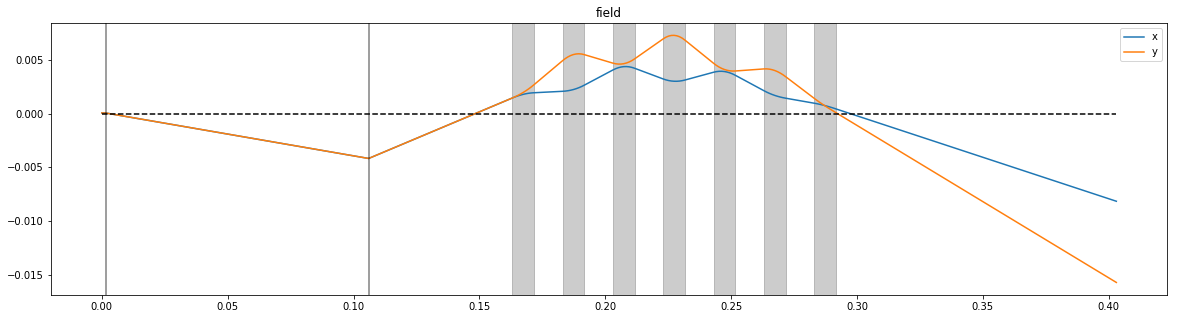

In [408]:
quad_gauss=.8

traj4=Transport()

traj4.set_kV(100)

traj4.set_ray('axial', x_angle=.5, y_angle=.5)

traj4.set_ray('field', x=6e-5, y=6e-5)

traj4.add_drift('drift_sample', length=0.0015)

traj4.add_lens('ObjL', f_length=.001479)

# traj4.add_lens('ObjL', f_length=.00149)

traj4.add_drift('drift_ObjL', length=.0885)

traj4.add_drift('drift1_1', length=.016)

traj4.add_lens('lens1', f_length=.03)

traj4.add_drift('drift1_2', length=.044)

traj4.add_drift('drift_prequad', length=.013)

traj4.add_quad('quad1', length=.008625, gauss=quad_gauss, radius=.625)

traj4.add_drift('drift1', length=.011375)

traj4.add_quad('quad2', length=.008625, gauss=-quad_gauss, radius=.625)

traj4.add_drift('drift2', length=.011375)

traj4.add_quad('quad3', length=.008625, gauss=quad_gauss, radius=.625)

traj4.add_drift('drift3', length=.011375)

traj4.add_quad('quad4', length=.008625, gauss=-quad_gauss, radius=.625)

traj4.add_drift('drift4', length=.011375)

traj4.add_quad('quad5', length=.008625, gauss=quad_gauss, radius=.625)

traj4.add_drift('drift5', length=.011375)

traj4.add_quad('quad6', length=.008625, gauss=-quad_gauss, radius=.625)

traj4.add_drift('drift6', length=.011375)

traj4.add_quad('quad7', length=.008625, gauss=quad_gauss, radius=.625)

traj4.add_drift('drift7', length=.011375)

# traj4.add_quad('quad8', length=.008625, gauss=-quad_gauss, radius=.625)

# traj4.add_drift('drift8', length=.011375)

# traj4.add_quad('quad9', length=.008625, gauss=quad_gauss, radius=.625)

# traj4.add_drift('drift9', length=.011375)

# traj4.add_quad('quad10', length=.008625, gauss=-quad_gauss, radius=.625)

# traj4.add_drift('drift10', length=.011375)

# traj4.add_quad('quad11', length=.008625, gauss=quad_gauss, radius=.625)

# traj4.add_drift('drift11', length=.011375)

# traj4.add_quad('quad12', length=.008625, gauss=-quad_gauss, radius=.625)

# traj4.add_drift('drift12', length=.011375)

traj4.add_drift('drift_final', length=.1)

traj4.plot()




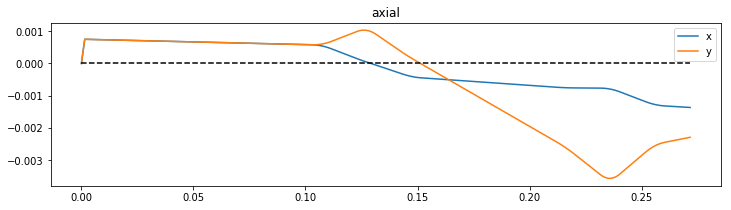

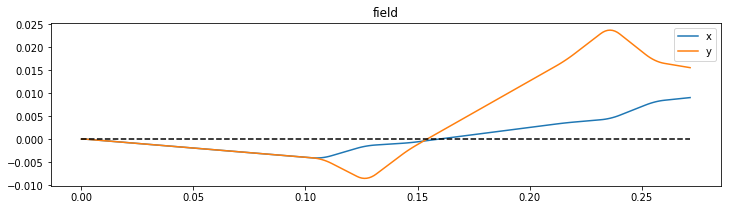

In [312]:
#  1.39971575 -1.21109938  0.75588434  0.09208673 -0.5244377   0.28542125

traj3=Transport()

traj3.set_kV(100)

traj3.set_ray('axial', x_angle=.5, y_angle=.5)

traj3.set_ray('field', x=6e-5, y=6e-5)

traj3.add_drift('drift_sample', length=0.0015)

traj3.add_lens('ObjL', f_length=.001495)

traj3.add_drift('drift_ObjL', length=.0885)

traj3.add_drift('drift_pre15', length=.013)

traj3.add_quad('quad15', length=.008625, gauss=.7571575, radius=.625)

traj3.add_drift('drift15', length=.011375)

traj3.add_quad('quad14', length=.008625, gauss=-1.21109938, radius=.625)

traj3.add_drift('drift14', length=.011375)

traj3.add_quad('quad13', length=.008625, gauss=0.75588434, radius=.625)

traj3.add_drift('drift13_1', length=.01)
traj3.add_drift('drift13_2', length=.05)

traj3.add_quad('quad12', length=.008625, gauss=0.09208673, radius=.625)

traj3.add_drift('drift12', length=.011375)

traj3.add_quad('quad11', length=.008625, gauss=-0.5244377, radius=.625)

traj3.add_drift('drift11', length=.011375)

traj3.add_quad('quad10', length=.008625, gauss=0.28542125, radius=.625)

traj3.add_drift('drift10', length=.011375)

# traj3.add_quad('quad8', length=.008625, gauss=0.421450576246005, radius=.625)

# traj3.add_drift('drift8', length=.02)

# traj3.add_quad('quad7', length=.008625, gauss=-0.64213391841801, radius=.625)

# traj3.add_drift('drift7', length=.0299)

# traj3.add_quad('quad6', length=.008625, gauss=0.861744949262271, radius=.625)

# traj3.add_drift('drift6', length=.0162)

# traj3.add_quad('quad5', length=.008625, gauss=0., radius=.625)

# traj3.add_drift('drift5', length=.0162)

# traj3.add_quad('quad4', length=.008625, gauss=-0.861744949262271, radius=.625)

# traj3.add_drift('drift4', length=.0299)

# traj3.add_quad('quad3', length=.008625, gauss=0.64213391841801, radius=.625)

# traj3.add_drift('drift3', length=.02)

# traj3.add_quad('quad2', length=.008625, gauss=-0.421450576246005, radius=.625)

# traj3.add_drift('drift2', length=.029)

# traj3.add_lens('lens3', f_length=.1)

# traj3.add_drift('drift_final', length=.1)

traj3.plot()

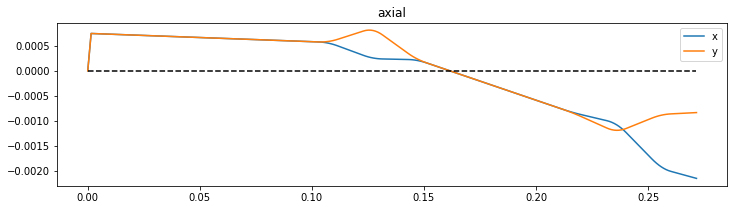

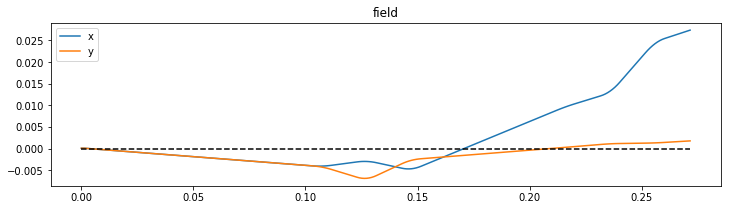

In [304]:
traj3.fit_quad_point_to_point(['quad15', 'quad14', 'quad13'])

traj3.plot()

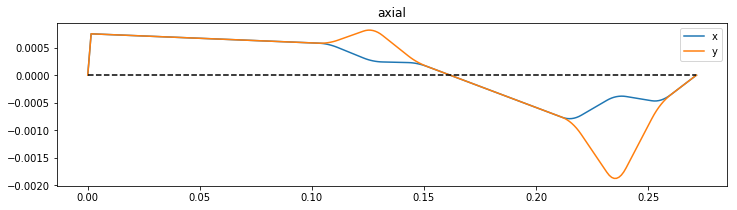

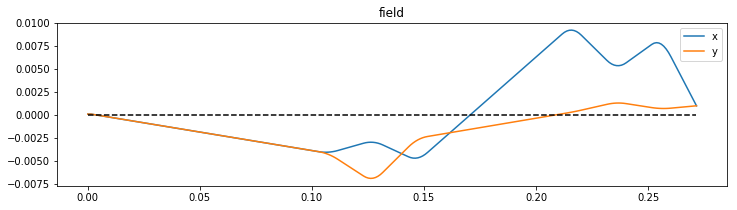

In [305]:
traj3.fit_quad_point_to_point(['quad12', 'quad11', 'quad10'])

traj3.plot()

C:\Users\Ben\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:161: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


[ 0.56252314 -0.72878625  0.05378471  0.00696032  0.09871688 -0.51581415
  0.28754776]


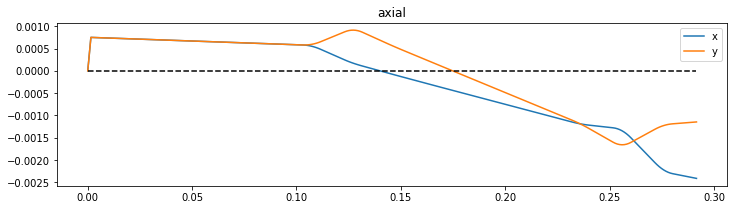

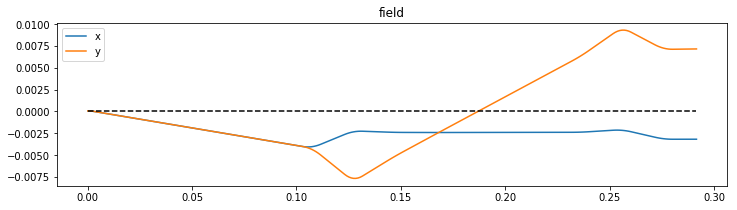

In [296]:
sol = traj3.fit_six_quad(['quad16', 'quad15', 'quad14', 'quad13', 'quad12', 'quad11', 'quad10'])

print(sol)

traj3.plot()

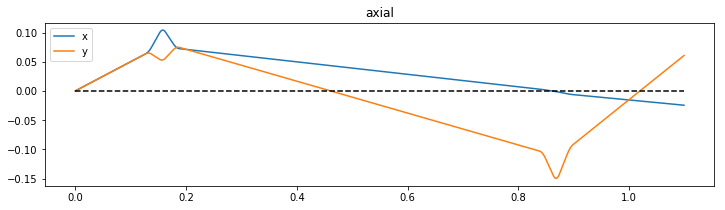

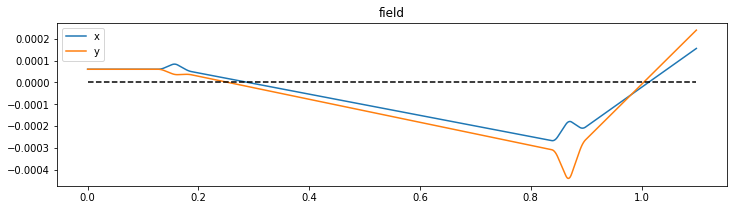

In [273]:
traj1=Transport()

traj1.set_kV(100)

# traj1.set_ray('axial', x_angle=1/0.6/342.9, y_angle=1/0.6/342.9)
# # traj1.set_ray('axial1', x_angle=0.1, y_angle=.1)
# traj1.set_ray('field', x=.0001, y=0.0001)

traj1.set_ray('axial', x_angle=.5, y_angle=.5)
traj1.set_ray('field', x=6e-5, y=6e-5)


# traj1.add_drift('drift0', length=0.0015)

# traj1.add_lens('ObjL', f_length=.001479)

traj1.add_drift('drift1', length=.1045)

traj1.add_drift('drift1', length=.127)

traj1.add_quad('quad1', length=.011, gauss=-.23, radius=.65)

traj1.add_drift('drift2', length=.014)

traj1.add_quad('quad2', length=.011, gauss=.40, radius=.65)

traj1.add_drift('drift3', length=.014)

traj1.add_quad('quad3', length=.011, gauss=-.23, radius=.65)

traj1.add_drift('drift4_1', length=.15)
traj1.add_drift('drift4_2', length=.5)

traj1.add_quad('quad4', length=.011, gauss=.22, radius=.65)

traj1.add_drift('drift5', length=.014)

traj1.add_quad('quad5', length=.011, gauss=-.4, radius=.65)

traj1.add_drift('drift6', length=.014)

traj1.add_quad('quad6', length=.011, gauss=.22, radius=.65)

traj1.add_drift('drift7', length=.2)

traj1.plot()

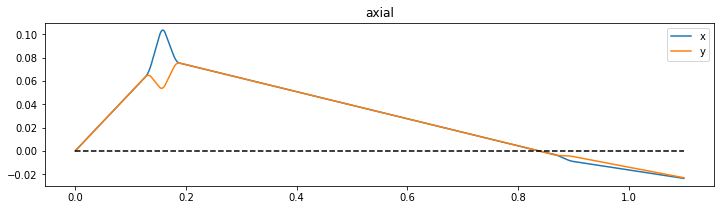

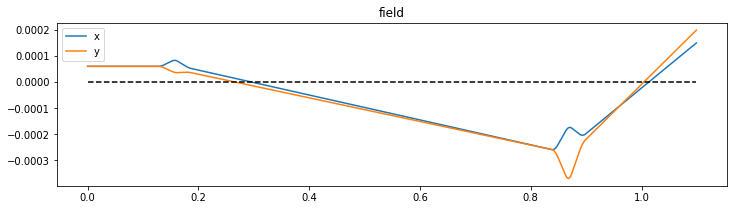

In [274]:
traj1.fit_quad_point_to_point(['quad1', 'quad2', 'quad3'])

traj1.plot()

[ 0.17520264 -0.33587757  0.18736178]


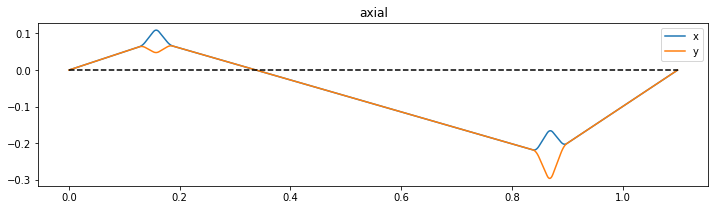

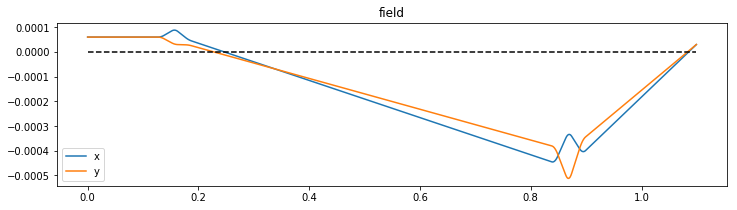

In [152]:
sol = traj1.fit_quad_point_to_point(['quad4', 'quad5', 'quad6'])

print(sol)

traj1.plot()

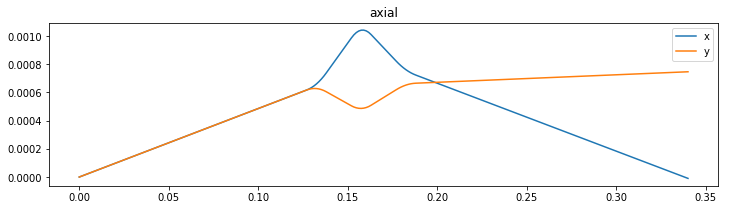

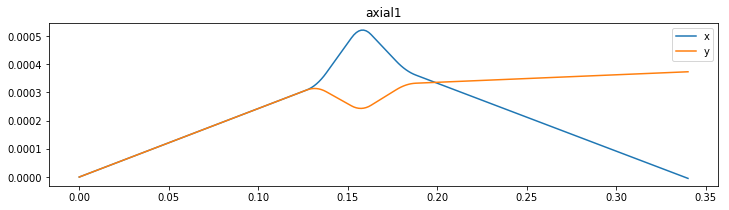

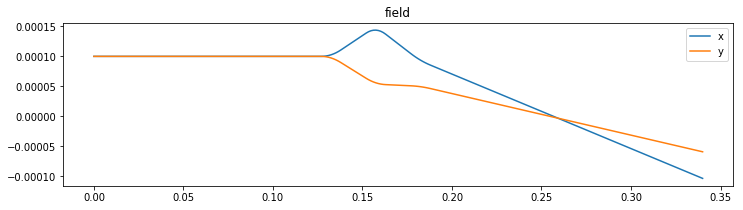

In [56]:
# traj1.ray_goal(goal=0.0075,
#                in_label='quad1', 
#                in_param='gauss', 
#                out_label='drift4', 
#                out_ray='axial', 
#                out_axis='y')

traj1.ray_goal(goal=0.00075,
               in_label='quad1', 
               in_param='gauss', 
               out_label='drift4', 
               out_ray='axial', 
               out_axis='x')

traj1.ray_goal(goal=0,
               in_label='quad3', 
               in_param='gauss', 
               out_label='drift5', 
               out_ray='axial', 
               out_axis='x')

# traj1.ray_goal(goal=0.00075,
#                in_label='quad2', 
#                in_param='gauss', 
#                out_label='drift4', 
#                out_ray='axial', 
#                out_axis='y')

# traj1.ray_goal(goal=0,
#                in_label='quad3', 
#                in_param='gauss', 
#                out_label='drift5', 
#                out_ray='axial', 
#                out_axis='y')

traj1.plot()

In [57]:
#     def ray_func(self, in_label, in_param, in_val, out_ray, out_axis):
#         self.elements[in_label][in_param] = in_val
#         self.crunch()
        
#         layer = self.elements[out_label]['layer']
#         return self.rays[out_ray][out_axis][layer]

traj1.ray_func(-0.41,in_label='quad2', 
               in_param='gauss',  
               out_label='quad3', 
               out_ray='axial', 
               out_axis='y')

5.728999549134807e-05

In [58]:
traj1.elements['quad1']['gauss']=-.22
traj1.crunch()
traj1.rays['axial']['x']

[0.0,
 0.000617283950617284,
 0.0007298320246604874,
 0.0009526330619928415,
 0.0013051976646759331,
 0.0020052329397405493,
 0.0026922435068185845,
 0.014121633657739234,
 0.014274025526418176]

In [59]:
traj1.elements['quad1']['gauss']=-.22
traj1.crunch()
traj1.axial_width_x

array([1.27000000e-05, 1.50155641e-05, 1.95994726e-05, 2.68531368e-05,
       4.12556625e-05, 5.53902179e-05, 2.90538491e-04, 2.93673801e-04])

In [60]:
traj1.elements['quad1']['gauss']=-.23

traj1.crunch()

print(traj1.elements['quad1']['gauss'])

-0.23


In [61]:
# def map_func(self, in_vec, in_labels, in_params, out_label, out_mx, out_my):
#     for idx, in_val in enumerate(in_vec):
#         self.elements[in_labels[idx]][in_params[idx]] = in_val
#     self.crunch()
#     layer = self.elements[out_label]['layer']
#     map_layer=self.map_layers[layer]
#     return map_layer[out_mx, out_my]

In [62]:
traj1.map_func([.4, .22], ['quad2', 'quad3'], ['gauss', 'gauss'], 'drift5', [0,2], [1,3])

# traj1.plot()

[-0.6723249598049568, 0.8801129206132741, -7.599271429932047]

In [63]:
sol=fsolve(traj1.map_func, [-.22, .4,  -0.22], 
       (['quad1', 'quad2', 'quad3'], ['gauss', 'gauss', 'gauss'], 'drift5', [0,2], [1,3]))

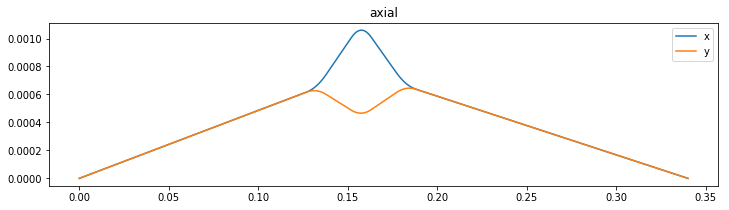

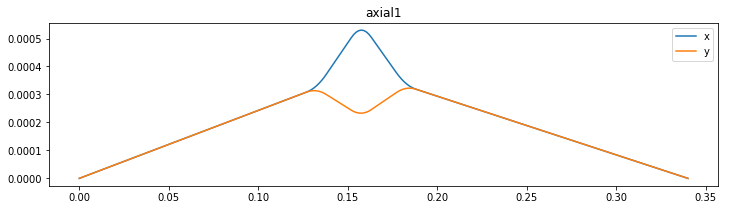

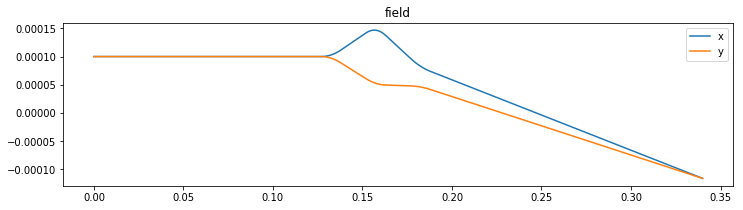

In [64]:
traj1.map_func([*sol], ['quad1', 'quad2', 'quad3'], ['gauss', 'gauss', 'gauss'], 'drift5', [0,2], [1,3])

traj1.plot()

In [108]:
sol

array([-0.27427179,  0.46599576, -0.26724456])

C:\Users\Ben\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: RuntimeWarning: invalid value encountered in double_scalars
  
C:\Users\Ben\Anaconda3\lib\site-packages\ipykernel_launcher.py:17: RuntimeWarning: invalid value encountered in double_scalars


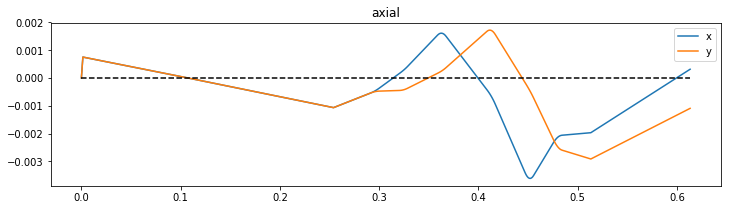

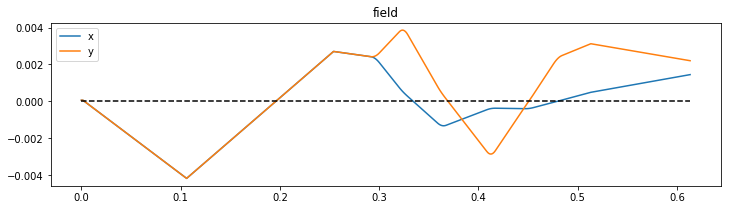

In [148]:
traj2=Transport()

traj2.set_kV(100)

traj2.set_ray('axial', x_angle=.5, y_angle=.5)

traj2.set_ray('field', x=6e-5, y=6e-5)

traj2.add_drift('drift0', length=0.0015)

traj2.add_lens('ObjL', f_length=.001479)

traj2.add_drift('drift1', length=.1045)

traj2.add_lens('lens1', f_length=.048)

traj2.add_drift('drift2', length=.148)

traj2.add_lens('lens2', f_length=.05)

traj2.add_drift('drift3', length=.0376)

traj2.add_quad('quad8', length=.008625, gauss=0.421450576246005, radius=.625)

traj2.add_drift('drift4', length=.02)

traj2.add_quad('quad7', length=.008625, gauss=-0.64213391841801, radius=.625)

traj2.add_drift('drift5', length=.0299)

traj2.add_quad('quad6', length=.008625, gauss=0.861744949262271, radius=.625)

traj2.add_drift('drift6', length=.0162)

traj2.add_quad('quad5', length=.008625, gauss=0., radius=.625)

traj2.add_drift('drift7', length=.0162)

traj2.add_quad('quad4', length=.008625, gauss=-0.861744949262271, radius=.625)

traj2.add_drift('drift8', length=.0299)

traj2.add_quad('quad3', length=.008625, gauss=0.64213391841801, radius=.625)

traj2.add_drift('drift9', length=.02)

traj2.add_quad('quad2', length=.008625, gauss=-0.421450576246005, radius=.625)

traj2.add_drift('drift10', length=.029)

traj2.add_lens('lens3', f_length=.1)

traj2.add_drift('drift11', length=.1)

traj2.plot()